## Assignment 1 - NBC

## preprocessing: packages

In [216]:
from nltk.corpus import stopwords
import pandas as pd
import re
from bs4 import BeautifulSoup
from textblob import TextBlob # for correcting spelling mistakes
from nltk.stem import PorterStemmer
import unicodedata
import spacy
import math
from random import choice
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

## preprocessing: read data

In [217]:
url = '/Users/cao.yumin/Desktop/UA第二学期/NLP/imdb_master.csv'

data = pd.read_csv(url,encoding = 'ISO-8859-1',index_col=0)
data.head()

,type,review,label,file
0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [218]:
data.isnull().sum()

type      0
review    0
label     0
file      0
dtype: int64

## preprocessing: stopwords

In [219]:
stop_words = stopwords.words('english')
print(stop_words[:20])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


In [220]:
useless_words = ['film','films','movie','movies','actor','actors','actress','actresses','scene','scenes']
stop_words.extend(useless_words)

In [221]:
stop_words.remove('not')
stop_words.remove('no')

In [222]:
'not' in stop_words

False

In [223]:
'no' in stop_words

False

In [224]:
drop_unsup = data[data['label'] != 'unsup']

In [225]:
drop_unsup.count()

type      50000
review    50000
label     50000
file      50000
dtype: int64

In [226]:
drop_unsup.groupby(['type']).count()

,review,label,file
type,,,
test,25000,25000,25000
train,25000,25000,25000


In [227]:
review = drop_unsup['review']
review.head()

0    Once again Mr. Costner has dragged out a movie...
1    This is an example of why the majority of acti...
2    First of all I hate those moronic rappers, who...
3    Not even the Beatles could write songs everyon...
4    Brass pictures (movies is not a fitting word f...
Name: review, dtype: object

## preprocessing: train_test_split

In [228]:
def train_test_split(df):
    train = df[df['type'] == 'train']
    test = df[df['type'] == 'test']
    review_train = train['review']
    label_train = train['label']
    review_test = test['review']
    label_test = test['label']
    return review_train, label_train, review_test, label_test

In [229]:
x_train, y_train, x_test, y_test = train_test_split(drop_unsup)

## preprocessing: clean data

### Lower

In [230]:
def lower(df):
    new_df = df.apply(lambda x: " ".join(x.lower() for x in x.split()))
    return new_df

In [231]:
new_x_train = lower(x_train)
new_x_test = lower(x_test)
new_x_train.head()

25000    story of a man who has unnatural feelings for ...
25001    airport '77 starts as a brand new luxury 747 p...
25002    this film lacked something i couldn't put my f...
25003    sorry everyone,,, i know this is supposed to b...
25004    when i was little my parents took me along to ...
Name: review, dtype: object

### HTML

In [232]:
def remove_html(df):
    new_df = df.apply(lambda x: BeautifulSoup(x, 'lxml'))
    new_df = new_df.apply(lambda x: x.text)
    return new_df

In [233]:
new_x_train = remove_html(new_x_train)
new_x_test = remove_html(new_x_test)

### URL

In [234]:
def remove_url(df):
    new_df = df.apply(lambda x: re.sub(r"http\S+", "", x))
    return new_df

In [235]:
new_x_train = remove_url(new_x_train)
new_x_test = remove_url(new_x_test)

### accented chars

In [236]:
def remove_accented_chars(df):
    data_list = []
    for text in df:
#         print(text)
        new_text = unicodedata.normalize('NFKD', text).encode('ISO-8859-1', 'ignore').decode('utf-8', 'ignore')
        data_list.append(new_text)
    new_df = pd.Series(data_list)
    return new_df

In [237]:
new_x_train = remove_accented_chars(new_x_train)
new_x_test = remove_accented_chars(new_x_test)

### stopwords

In [238]:
def remove_stopwords(df):
    new_df = df.apply(lambda x: " ".join(m for m in x.split() if m not in stop_words))
    return new_df

In [239]:
new_x_train = remove_stopwords(new_x_train)
new_x_test = remove_stopwords(new_x_test)

### extra whitespace

In [240]:
def remove_extra_whitespace_tabs(df):
    pattern = r'^\s*|\s\s*'
    data_list = []
    for text in df:
        new_text = re.sub(pattern, ' ', text).strip()
        data_list.append(new_text)
    new_df = pd.Series(data_list)
    return new_df

In [241]:
new_x_train = remove_extra_whitespace_tabs(new_x_train)
new_x_test = remove_extra_whitespace_tabs(new_x_test)

### punctuation remove "_"

In [242]:
# %load ./appos.py
appos = {
"aren't" : "are not","are'nt" : "are not",
"can't" : "can not","ca'nt" : "can not",
"couldn't" : "could not","could'nt" : "could not",
"didn't" : "did not", "did'nt" : "did not",
"doesn't" : "does not","does'nt" : "does not",
"don't" : "do not","do'nt" : "do not",
"hadn't" : "had not","had'nt" : "had not",
"hasn't" : "has not","has'nt" : "has not",
"haven't" : "have not","have'nt" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not","might'nt" : "might not",
"mustn't" : "must not","must'nt" : "must not",
"shan't" : "shall not","sha'nt" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not","should'nt" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not","were'nt" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not","was'nt": "was not",
"we'll":" will",
"didn't": "did not","did'nt": "did not"
}

In [243]:
def punctuation1(df):
    pun_data = df.str.replace('[_]','')
    return pun_data

In [244]:
new_x_train = punctuation1(new_x_train)
new_x_test = punctuation1(new_x_test)

### negation

In [245]:
def negation(df):  # 1st step: change nega_words structure, 2ed step: add NOT
    data_list = []
    for text in df:
        new_text = " ".join(appos[word] if word in appos else word for word in text.split())
        transformed = re.sub(r'\b(?:not|never|no)\b[\w\s]+[^\w\s]', 
                             lambda match: re.sub(r'(\s+)(\w+)', r'\1NOT_\2', match.group(0)), 
                             new_text,
                             flags=re.IGNORECASE)
        data_list.append(transformed)
    new_df = pd.Series(data_list)
    return new_df

In [246]:
new_x_train = negation(new_x_train)
new_x_test = negation(new_x_test)

### punctuation

In [247]:
def punctuation(df):
    pun_data = df.str.replace('[^\w\s_]','')
    return pun_data

In [248]:
new_x_train = punctuation(new_x_train)
new_x_test = punctuation(new_x_test)

## Stem and Lemmatization

In [249]:
ps = PorterStemmer()
def stemming(df):
    new_df = df.apply(lambda x: " ".join(ps.stem(word) for word in x.split()))
    return new_df

In [250]:
stem_x_train = stemming(new_x_train)
stem_x_test = stemming(new_x_test)

In [251]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def space(df):
    new_df = df.apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))
    return new_df

In [252]:
lemma_x_train = space(new_x_train)
lemma_x_test = space(new_x_test)

## Numbers

In [253]:
def remove_numbers(df):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]'
    pattern2 = r'^\s*|\s\s*'
    data_list = []
    for text in df:
        new_text = re.sub(pattern, '', text).strip()
#         print(new_text)
        new_text = re.sub(pattern2, ' ', new_text).strip()
        data_list.append(new_text)
    new_df = pd.Series(data_list)
    return new_df

In [254]:
stem_x_train = remove_numbers(stem_x_train)
stem_x_test = remove_numbers(stem_x_test)
lemma_x_train = remove_numbers(lemma_x_train)
lemma_x_test = remove_numbers(lemma_x_test)

In [255]:
stem_x_train = remove_stopwords(stem_x_train)
stem_x_test = remove_stopwords(stem_x_test)
lemma_x_train = remove_stopwords(lemma_x_train)
lemma_x_test = remove_stopwords(lemma_x_test)

## Basic NBC and F1 score

In [256]:
class BaselineNBClassifier:
    def __init__(self,x_train,y_train,ksmooth=1):
        self.x_train = x_train
        self.y_train = y_train
        self.word_counts, self.vocab, self.neg_count, self.pos_count = self.sum_num_classes()
        self.pos_prior, self.neg_prior = self.prior()
        self.ksmooth = ksmooth
    def token(self,df):
        new_df = df.apply(lambda x: re.split("\W+", x))
        return new_df
    def token_corpus(self,text):
        return re.split("\W+", text)
    def get_word_counts(self,text):
        corpus = self.token_corpus(text)
        g_word_counts = {}
        for word in corpus:
            g_word_counts[word] = g_word_counts.get(word, 0.0) + 1.0  # k smoothing
        return g_word_counts
    def prior(self):
        pos_prior = self.y_train[self.y_train=='pos'].count()/self.y_train.count()
        neg_prior = self.y_train[self.y_train=='neg'].count()/self.y_train.count()
        return pos_prior,neg_prior
    def sum_num_classes(self):
        word_counts = {'pos':{},'neg':{}}
        vocab = set()
        for x, y in zip(self.x_train, self.y_train):
            counts = self.get_word_counts(x)
            for word, count in counts.items():
                if word not in vocab:
                    vocab.add(word)
                if word not in word_counts[y]:
                    word_counts[y][word] = 0.0
                word_counts[y][word] += count
        n = 0
        p = 0
        for k in word_counts['pos']:
            p += word_counts['pos'][k]
        for k in word_counts['neg']:
            n += word_counts['neg'][k]
        
        ll = []
        for i in word_counts:
            for j in word_counts[i]:
                ll.append(word_counts[i][j])
        return word_counts,vocab,n,p
    def predict(self, x_test):
        result = []
        for text in x_test:
            counts = self.get_word_counts(text)
            neg_score = 1.0
            pos_score = 1.0
            for word, _ in counts.items(): # how to deal with unknown words
                if word not in self.vocab:
                    continue
                w_given_pos = (self.word_counts['pos'].get(word, 0.0) + self.ksmooth) / (self.pos_count + self.ksmooth*len(self.vocab))
                w_given_neg = (self.word_counts['neg'].get(word, 0.0) + self.ksmooth) / (self.neg_count + self.ksmooth*len(self.vocab))

                pos_score *= w_given_pos
                neg_score *= w_given_neg

            pos_score = self.pos_prior * pos_score
            neg_score = self.neg_prior * neg_score

            if pos_score > neg_score:
                result.append('pos')
            elif pos_score < neg_score:
                result.append('neg')
            elif pos_score == neg_score:
                chois = choice(['pos','neg'])
                result.append(chois)
        return result
    def evaluate(self,x_test,y_test):
        TP = 0
        FP = 0
        FN = 0
        TN = 0
        predict_y = self.predict(x_test)
        for i in range(len(predict_y)):
            if predict_y[i] == y_test[i]:
                if y_test[i] == 'pos':
                    TP += 1
                elif y_test[i] == 'neg':
                    TN += 1
            if predict_y[i] != y_test[i]:
                if y_test[i] == 'pos':
                    FN += 1
                elif y_test[i] == 'neg':
                    FP += 1
        precision = TP/(TP+FP)
        recall = TP/(TP+FN)
        F1_score = 2*precision*recall/(precision+recall)
        return F1_score,precision,recall

## Pipeline

In [ ]:
def preprocessing_pipeline(x): # x is x_train and x_test after splitting
    new_x = lower(x)
    new_x = remove_html(new_x)
    new_x = remove_url(new_x)
    new_x = remove_accented_chars(new_x)
    new_x = remove_stopwords(new_x)
    new_x = remove_extra_whitespace_tabs(new_x)
    new_x = punctuation1(new_x)
    new_x = negation(new_x)
    new_x = punctuation(new_x)
    return new_x

## Evaluate: stem and lemma

In [42]:
object = BaselineNBClassifier(stem_x_train,y_train)
F1_score,precision,recall = object.evaluate(stem_x_test,y_test)
print('F1 score: ',F1_score)
print('Precision: ',precision)
print('Recall: ',recall)

F1 score:  0.6946439823566478
Precision:  0.7313578062804069
Recall:  0.66144


In [43]:
object2 = BaselineNBClassifier(lemma_x_train,y_train)
F1_score,precision,recall = object2.evaluate(lemma_x_test,y_test)
print('F1 score: ',F1_score)
print('Precision: ',precision)
print('Recall: ',recall)

F1 score:  0.6994896678658077
Precision:  0.733035244608101
Recall:  0.66888


## Evaluate: unknown words
###                           TF-IDF for unknown words

In [46]:
def TF_IDF(df):
    Tcorpus = [text for text in df]
    vectorizer=CountVectorizer()
    transformer=TfidfTransformer()
    tfidf=transformer.fit_transform(vectorizer.fit_transform(Tcorpus))
    words=vectorizer.get_feature_names()
    weight=tfidf.toarray()
    return words,weight

#     useless_words = []
#     for i in range(len(words)):
#         sum = 0
#         for j in range(len(weight)):
#             sum += weight[j][i]
#         if sum == 0:
#             useless_words.append(words[i])
#     return useless_words

In [47]:
words,weight = TF_IDF(stem_x_train)

In [159]:
len(words),len(weight)

(122243, 25000)

##  \<unk> for unknown words

In [290]:
class UnkNBC(BaselineNBClassifier):
    def __init__(self,x_train,y_train,ksmooth=1,threshold=1):
        self.x_train = x_train
        self.y_train = y_train
        self.ksmooth = ksmooth
        self.threshold = threshold
        self.word_counts, self.vocab, self.neg_count, self.pos_count = self.sum_num_classes()
        self.pos_prior, self.neg_prior = self.prior()
    def sum_num_classes(self):
        word_counts = {'pos':{},'neg':{}}
        vocab = set()
        for x, y in zip(self.x_train, self.y_train):
            counts = self.get_word_counts(x)
            for word, count in counts.items():
                if word not in vocab:
                    vocab.add(word)
                if word not in word_counts[y]:
                    word_counts[y][word] = 0.0
                word_counts[y][word] += count
        
        unk_list = []
        new_word_counts = {'pos':{'unk':0.0},'neg':{'unk':0.0}}
        new_vocab = set()
        new_vocab.add('unk')
        for i in word_counts:
            for j in word_counts[i]:
                if word_counts[i][j] <= self.threshold:
                    new_word_counts[i]['unk'] += 1
                    new_vocab.add('unk')
                else:
                    if j not in new_word_counts[i]:
                        new_word_counts[i][j] = 0.0
                        new_vocab.add(j)
                    new_word_counts[i][j] = word_counts[i][j]
        n = 0
        p = 0
        for k in new_word_counts['pos']:
            p += new_word_counts['pos'][k]
        for k in new_word_counts['neg']:
            n += new_word_counts['neg'][k]
        '''
        -test
        '''    
#         print(new_word_counts)
#         print(new_vocab,len(new_vocab))
#         print(n)
#         print(p)
        
        return new_word_counts,new_vocab,n,p
    def predict(self, x_test):
        result = []
        for text in x_test:
            counts = self.get_word_counts(text)
            neg_score = 1.0
            pos_score = 1.0
            for word, _ in counts.items(): # how to deal with unknown words
                if word not in self.vocab:
                    unk_given_pos = (self.word_counts['pos'].get('unk', 0.0) + self.ksmooth) / (self.pos_count + self.ksmooth*len(self.vocab))
                    unk_given_neg = (self.word_counts['neg'].get('unk', 0.0) + self.ksmooth) / (self.neg_count + self.ksmooth*len(self.vocab))
                    pos_score *= unk_given_pos
                    neg_score *= unk_given_neg
                else: 
                    w_given_pos = (self.word_counts['pos'].get(word, 0.0) + self.ksmooth) / (self.pos_count + self.ksmooth*len(self.vocab))
                    w_given_neg = (self.word_counts['neg'].get(word, 0.0) + self.ksmooth) / (self.neg_count + self.ksmooth*len(self.vocab))
                    pos_score *= w_given_pos
                    neg_score *= w_given_neg

            pos_score = self.pos_prior * pos_score
            neg_score = self.neg_prior * neg_score

            if pos_score > neg_score:
                result.append('pos')
            elif pos_score < neg_score:
                result.append('neg')
            elif pos_score == neg_score:
                chois = choice(['pos','neg'])
                result.append(chois)
        return result

In [270]:
unkobject = UnkNBC(stem_x_train,y_train)
F1_score,precision,recall = unkobject.evaluate(stem_x_test,y_test)
print('F1 score: ',F1_score)
print('Precision: ',precision)
print('Recall: ',recall)

F1 score:  0.695801991847712
Precision:  0.7328494290519607
Recall:  0.66232


## Evaluate: smooth
### k-smooth

In [193]:
ksmooth_list = [0.01,0.1,0.5,1,3,5,7,9,15,20,30,50,100,500,1000,3000,500000]
score_list = []
for k in ksmooth_list:
    new_object = BaselineNBClassifier(stem_x_train,y_train,ksmooth=k)
    F1_score,_,_ = new_object.evaluate(stem_x_test,y_test)
    score_list.append((F1_score,k))

In [194]:
score_list

[(0.669255117113315, 0.01),
 (0.6836548653805385, 0.1),
 (0.6925307889538062, 0.5),
 (0.6927299392415671, 1),
 (0.7002326354270522, 3),
 (0.7056146303115561, 5),
 (0.699958762886598, 7),
 (0.7056118888295907, 9),
 (0.7071093909146466, 15),
 (0.7045287637698899, 20),
 (0.7039792947266258, 30),
 (0.7021164663510178, 50),
 (0.690346743989368, 100),
 (0.6654331912155096, 500),
 (0.6573759896590725, 1000),
 (0.6389259573779774, 3000),
 (0.5987434901215177, 500000)]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

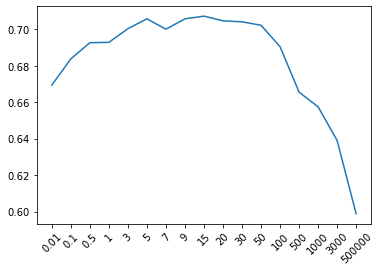

In [196]:
a = [x[0] for x in score_list]
b = [x[1] for x in score_list]
plt.plot(['0.01','0.1','0.5','1','3','5','7','9','15','20','30','50',
          '100','500','1000','3000','500000'],a)
plt.xticks(rotation=45)

## Evaluate: \<unk> thresholds

In [271]:
thres_list = [1,2,3,5,10,20,50,100,500,1000,3000,5000]
score_list = []
for k in thres_list:
    new_object = UnkNBC(stem_x_train,y_train,threshold=k)
    F1_score,_,_ = new_object.evaluate(stem_x_test,y_test)
    score_list.append((F1_score,k))

In [272]:
score_list

[(0.6924861831835633, 1),
 (0.695359218394677, 2),
 (0.6950941484421177, 3),
 (0.6916014385445313, 5),
 (0.6963244613434727, 10),
 (0.7005336358670533, 20),
 (0.7086002396991361, 50),
 (0.7210502784213306, 100),
 (0.7443939031202618, 500),
 (0.7539177657098526, 1000),
 (0.6737455437574271, 3000),
 (0.6756356089244682, 5000)]

In [292]:
UnkNBC(stem_x_train,y_train,threshold=1000).vocab

{'I',
 'absolut',
 'act',
 'action',
 'actual',
 'almost',
 'also',
 'although',
 'alway',
 'amaz',
 'american',
 'anim',
 'anoth',
 'anyon',
 'anyth',
 'appear',
 'around',
 'attempt',
 'audienc',
 'aw',
 'away',
 'back',
 'bad',
 'beauti',
 'becom',
 'begin',
 'believ',
 'best',
 'better',
 'big',
 'bit',
 'book',
 'bore',
 'boy',
 'call',
 'cast',
 'chang',
 'charact',
 'classic',
 'come',
 'comedi',
 'complet',
 'could',
 'cours',
 'day',
 'definit',
 'differ',
 'direct',
 'director',
 'disappoint',
 'done',
 'dvd',
 'effect',
 'els',
 'emot',
 'end',
 'enjoy',
 'enough',
 'entertain',
 'entir',
 'episod',
 'especi',
 'even',
 'ever',
 'everi',
 'everyon',
 'everyth',
 'excel',
 'expect',
 'face',
 'fact',
 'fail',
 'famili',
 'fan',
 'far',
 'father',
 'favorit',
 'feel',
 'final',
 'find',
 'first',
 'follow',
 'found',
 'friend',
 'fun',
 'funni',
 'get',
 'girl',
 'give',
 'go',
 'goe',
 'good',
 'got',
 'great',
 'guy',
 'half',
 'happen',
 'hard',
 'head',
 'help',
 'hope',
 

In [291]:
UnkNBC(stem_x_train,y_train,threshold=500).vocab - UnkNBC(stem_x_train,y_train,threshold=1000).vocab

{'abl',
 'add',
 'age',
 'ago',
 'allow',
 'along',
 'alreadi',
 'annoy',
 'anyway',
 'apart',
 'appar',
 'appreci',
 'art',
 'ask',
 'atmospher',
 'avoid',
 'badli',
 'base',
 'basic',
 'behind',
 'black',
 'blood',
 'bodi',
 'brilliant',
 'bring',
 'brother',
 'budget',
 'bunch',
 'came',
 'camera',
 'cannot',
 'captur',
 'car',
 'care',
 'career',
 'case',
 'certainli',
 'chanc',
 'charm',
 'cheap',
 'child',
 'children',
 'cinema',
 'cinematographi',
 'citi',
 'close',
 'comic',
 'comment',
 'confus',
 'consid',
 'continu',
 'countri',
 'coupl',
 'crap',
 'creat',
 'credit',
 'critic',
 'cut',
 'danc',
 'dark',
 'daughter',
 'david',
 'dead',
 'deal',
 'death',
 'decent',
 'decid',
 'deliv',
 'deserv',
 'despit',
 'develop',
 'dialog',
 'dialogu',
 'die',
 'discov',
 'documentari',
 'drama',
 'dream',
 'dull',
 'earli',
 'edit',
 'effort',
 'either',
 'element',
 'etc',
 'event',
 'evil',
 'exampl',
 'except',
 'experi',
 'extrem',
 'eye',
 'fall',
 'fantast',
 'featur',
 'felt',
 

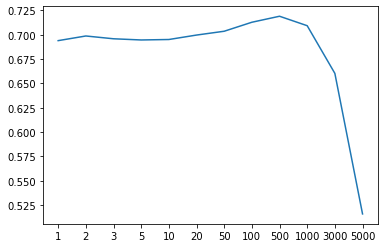

In [192]:
a = [x[0] for x in score_list]
b = [x[1] for x in score_list]
plt.plot(['1','2','3','5','10','20','50','100','500','1000','3000','5000'],a)

## Evaluate: optimizing combinations

In [293]:
ksmooth_list = [1,3,5,9,15,30,50]
thres_list = [50,100,500,1000]
score_list = []
for k in ksmooth_list:
    for t in thres_list:
        new_object = UnkNBC(stem_x_train,y_train,ksmooth=k,threshold=k)
        F1_score,_,_ = new_object.evaluate(stem_x_test,y_test)
        score_list.append((F1_score,k,t))

In [294]:
sorted(score_list,reverse=True)[:10]

[(0.7324038867765104, 50, 50),
 (0.729964051596532, 50, 1000),
 (0.7296, 50, 500),
 (0.7275031685678073, 50, 100),
 (0.7231413701180552, 30, 1000),
 (0.7207512054817697, 30, 500),
 (0.7207443434129838, 30, 50),
 (0.7189768698294784, 30, 100),
 (0.7148716647638378, 15, 500),
 (0.7133220910623946, 15, 1000)]

## Evaluate: Naive bayes classifier without smooth

In [107]:
class NosmoothNBClassifier(BaselineNBClassifier):
    def prior(self):
        log_pos_prior = math.log(self.y_train[self.y_train=='pos'].count()/self.y_train.count())
        log_neg_prior = math.log(self.y_train[self.y_train=='neg'].count()/self.y_train.count())
        return log_pos_prior,log_neg_prior
    def predict(self, x_test):
        result = []
        for text in x_test:
            counts = self.get_word_counts(text)
            neg_score = 0.0
            pos_score = 0.0
            for word, _ in counts.items(): # how to deal with unknown words
                if word not in self.vocab:
                    continue
                w_given_pos = math.log((self.word_counts['pos'].get(word, 0.0)) / (self.pos_count))
                w_given_neg = math.log((self.word_counts['neg'].get(word, 0.0)) / (self.neg_count))

                pos_score += w_given_pos
                neg_score += w_given_neg

            pos_score = self.pos_prior + pos_score
            neg_score = self.neg_prior + neg_score

            if pos_score > neg_score:
                result.append('pos')
            elif pos_score < neg_score:
                result.append('neg')
            elif pos_score == neg_score:
                chois = choice(['pos','neg'])
                result.append(chois)
        return result

In [108]:
nos_object =  NosmoothNBClassifier(stem_x_train,y_train)
try:
    F1_score,precision,recall = nos_object.evaluate(stem_x_test,y_test)
    print('F1 score: ',F1_score)
except ValueError:
    print('math domain error because of 0')

math domain error because of 0


## Evaluate: words-frequency distribution

In [102]:
def token_corpus(text):
    return re.split("\W+", text)
def get_word_counts(text):
    corpus = token_corpus(text)
    g_word_counts = {}
    for word in corpus:
        g_word_counts[word] = g_word_counts.get(word, 0.0) + 1.0  # k smoothing
    return g_word_counts
def sum_num_classes(stem_x_train,y_train):
    word_counts = {'pos':{},'neg':{}}
    vocab = set()
    for x, y in zip(stem_x_train, y_train):
        counts = get_word_counts(x)
        for word, count in counts.items():
            if word not in vocab:
                vocab.add(word)
            if word not in word_counts[y]:
                word_counts[y][word] = 0.0
            word_counts[y][word] += count
    n = 0
    p = 0
    for k in word_counts['pos']:
        p += word_counts['pos'][k]
    for k in word_counts['neg']:
        n += word_counts['neg'][k]

    ll = []
    for i in word_counts:
        for j in word_counts[i]:
            ll.append(word_counts[i][j])
    return ll

In [103]:
ll = sum_num_classes(stem_x_train,y_train)

In [109]:
one_five = 0
five_ten = 0
ten_fif = 0
fif_hud = 0
hud_hud3 = 0
hud3_hud5 = 0
hud5_hudd = 0
hudd_hudd3 = 0
hudd3_hudd5 = 0
hudd5 = 0
for i in ll:
    if i <= 5:
        one_five += 1
    elif 6 <= i and i <= 10:
        five_ten +=1
    elif 11 <= i and i <= 50:
        ten_fif += 1
    elif 51 <= i and i <= 100:
        fif_hud += 1
    elif 101 <= i and i <= 300:
        hud_hud3 += 1
    elif 301 <= i and i <= 500:
        hud3_hud5 += 1
    elif 501 <= i and i <= 1000:
        hud5_hudd += 1
    elif 1001 <= i and i <= 3000:
        hudd_hudd3 += 1
    elif 3001 <= i and i <= 5000:
        hudd3_hudd5 += 1
    elif 5001 <= i:
        hudd5 += 1
print(one_five,five_ten,ten_fif,fif_hud,hud_hud3,hud3_hud5,hud5_hudd,hudd_hudd3,hudd3_hudd5,hudd5)

z = len(ll)//2
zhong = (ll[z]+ll[::-1][z])/2
print(zhong)
print(z)

124305 9390 13141 3042 2589 697 528 370 54 37
1.0
77076


In [188]:
num_list = [one_five,five_ten,ten_fif,fif_hud,hud_hud3,hud3_hud5,hud5_hudd,hudd_hudd3,hudd3_hudd5,hudd5]
name_list = ['one_five','five_ten','ten_fif','fif_hud','hud_hud3','hud3_hud5','hud5_hudd',
             'hudd_hudd3','hudd3_hudd5','hudd5']

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

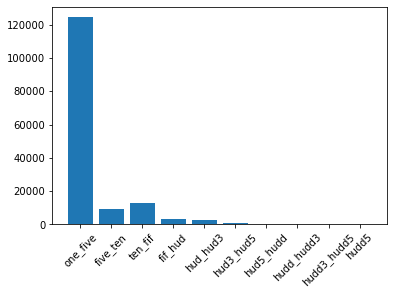

In [190]:
plt.bar(name_list, num_list) 
plt.xticks(rotation=45) 

## Evaluate: bigram naive bayes classifier

In [267]:
class NgramNBC(BaselineNBClassifier):
    def __init__(self,x_train,y_train,ksmooth=1):
        self.x_train = x_train
        self.y_train = y_train
        self.word_counts, self.vocab, self.neg_count, self.pos_count,self.single = self.sum_num_classes()
        self.pos_prior, self.neg_prior = self.prior()
        self.ksmooth = ksmooth
    def token_corpus(self,text):
        return text.split()
    def get_word_counts(self,text):
        corpus = self.token_corpus(text)
        g_word_counts = {}
        first_word_list = corpus[:-1]
        last_word_list = corpus[1:]
        for i in range(len(corpus)-1):
            new_word = first_word_list[i]+' '+last_word_list[i]
            g_word_counts[new_word] = g_word_counts.get(new_word, 0.0) + 1.0  # k smoothing
        return g_word_counts
    def sum_num_classes(self):
        word_counts = {'pos':{},'neg':{}}
        vocab = set()
        single_vocab = set()
        new_x_train = self.x_train.apply(lambda x: '<cls> '+x+' <end>')
        for x, y in zip(new_x_train, self.y_train):
            counts = self.get_word_counts(x)
            for word, count in counts.items():
                if word.split()[0] not in single_vocab:
                    single_vocab.add(word.split()[0])
                if word not in vocab:
                    vocab.add(word)
                if word not in word_counts[y]:
                    word_counts[y][word] = 0.0
                word_counts[y][word] += count
        n = 0
        p = 0
        for k in word_counts['pos']:
            p += word_counts['pos'][k]
        for k in word_counts['neg']:
            n += word_counts['neg'][k]
        
        single_word_counts = {'pos':{},'neg':{}}
        for n in single_vocab:
            single_word_counts['pos'][n] = 0.0
            single_word_counts['neg'][n] = 0.0
            
            pos_count = 0
            for i in word_counts['pos']:
                if i.startswith(n):
                    pos_count += word_counts['pos'][i]
            single_word_counts['pos'][n] += pos_count
            
            neg_count = 0
            for m in word_counts['neg']:
                if m.startswith(n):
                    neg_count += word_counts['neg'][m]
            single_word_counts['neg'][n] += neg_count
#         unk_list = []
#         new_word_counts = {'pos':{'unk':0.0},'neg':{'unk':0.0}}
#         new_vocab = set()
#         new_vocab.add('unk')
#         for i in word_counts:
#             for j in word_counts[i]:
#                 if word_counts[i][j] <= self.threshold:
#                     new_word_counts[i]['unk'] += 1
#                     new_vocab.add('unk')
#                 else:
#                     if j not in new_word_counts[i]:
#                         new_word_counts[i][j] = 0.0
#                         new_vocab.add(j)
#                     new_word_counts[i][j] = word_counts[i][j]
#         return new_word_counts,new_vocab,n,p
        return word_counts,vocab,n,p,single_word_counts
    def predict(self, x_test):
        result = []
        new_x_test = x_test.apply(lambda x: '<cls> '+x+' <end>')
        average_unk = 0.0
        for text in new_x_test:
            counts = self.get_word_counts(text)
            neg_score = 1.0
            pos_score = 1.0
            sum_unk = 0.01
            for word, _ in counts.items(): # how to deal with unknown words
                if word not in self.vocab:
#                     unk_given_pos = (self.word_counts['pos'].get('unk', 0.0) + self.ksmooth) / (pos_count + self.ksmooth*len(self.vocab))
#                     unk_given_neg = (self.word_counts['neg'].get('unk', 0.0) + self.ksmooth) / (neg_count + self.ksmooth*len(self.vocab))
#                     pos_score *= unk_given_pos
#                     neg_score *= unk_given_neg
                    sum_unk += 1
                    continue
                else: 
#                     pos_count = 0
#                     for i in self.word_counts['pos']:
#                         if i.startswith(first):
#                             pos_count += self.word_counts['pos'][i]
#                     neg_count = 0
#                     for m in self.word_counts['neg']:
#                         if m.startswith(first):
#                             neg_count += self.word_counts['neg'][m]
                    first,second = word.split()
                    print(first)
                    pos_count = self.single['pos'].get(first)
                    neg_count = self.single['neg'].get(first)
                    print(pos_count)
                    w_given_pos = (self.word_counts['pos'].get(word, 0.0) + self.ksmooth) / (pos_count + self.ksmooth*len(self.vocab))
                    w_given_neg = (self.word_counts['neg'].get(word, 0.0) + self.ksmooth) / (neg_count + self.ksmooth*len(self.vocab))
                    pos_score *= w_given_pos
                    neg_score *= w_given_neg

            pos_score = self.pos_prior * pos_score
            neg_score = self.neg_prior * neg_score

            if pos_score > neg_score:
                result.append('pos')
            elif pos_score < neg_score:
                result.append('neg')
            elif pos_score == neg_score:
                chois = choice(['pos','neg'])
                result.append(chois)
            sum_unk = sum_unk/ len(counts)
            average_unk += sum_unk
        average_unk /= len(new_x_test)
        return result,average_unk
    def evaluate(self,x_test,y_test):
        TP = 0
        FP = 0
        FN = 0
        TN = 0
        predict_y,average_unk = self.predict(x_test)
        for i in range(len(predict_y)):
            if predict_y[i] == y_test[i]:
                if y_test[i] == 'pos':
                    TP += 1
                elif y_test[i] == 'neg':
                    TN += 1
            if predict_y[i] != y_test[i]:
                if y_test[i] == 'pos':
                    FN += 1
                elif y_test[i] == 'neg':
                    FP += 1
        precision = TP/(TP+FP)
        recall = TP/(TP+FN)
        F1_score = 2*precision*recall/(precision+recall)
        return F1_score,precision,recall,average_unk

In [155]:
n_object =  NgramNBC(stem_x_train,y_train)
F1_score,precision,recall,average = n_object.evaluate(stem_x_test,y_test)
F1_score,precision,recall,average

(0.7663589081965893, 0.7724945135332846, 0.76032, 0.5894724264410482)